In [2]:
import sys

sys.path.append('..')

In [3]:
import torch

data = torch.load('../processed_data/complete_dataset/processed_data.pt')
label = torch.load('../processed_data/complete_dataset/processed_label.pt')

In [4]:
from audio_toolbox.metrics import audio_dataset_split

RANDOM_STATE = 42
X_train, y_train, _, _,\
X_test, y_test = audio_dataset_split(data, label, train_val_test_ratio=(0.9, 0, 0.1), random_state=RANDOM_STATE)

In [5]:
X_train_flat = X_train.view(X_train.shape[0], -1).cpu().numpy()
X_test_flat = X_test.view(X_test.shape[0], -1).cpu().numpy()

Do PCA on flattened features

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize the scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components=0.9) # Keep 90% of the variance

# Fit the scaler on the training set and transform all sets
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

reduced_X_train_flat = pca.fit_transform(X_train_scaled)
reduced_X_test_flat = pca.transform(X_test_scaled)

In [7]:
X_train = X_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()

In [8]:
print(f"Training samples: {X_train.shape} -> {reduced_X_train_flat.shape}")
print(f"Test samples: {X_test.shape} -> {reduced_X_test_flat.shape}")

Training samples: (899, 6, 12, 1290) -> (899, 661)
Test samples: (100, 6, 12, 1290) -> (100, 661)


Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 60.0000%, 40 mismatches out of 100 samples
(Averaged) Test precision: 0.6015, recall: 0.6275, f1 score: 0.5812


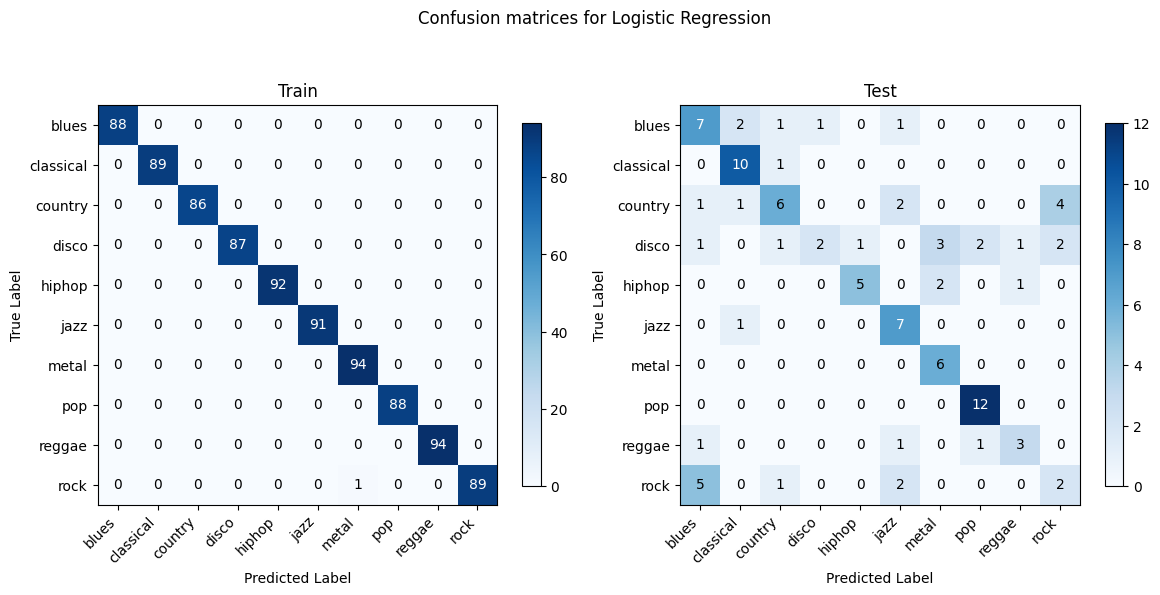

In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from audio_toolbox.metrics import calculate_acc, precision_recall, visualize_confusion_matrices

logistic_model = LogisticRegression(max_iter=3000, C=1e-3, random_state=RANDOM_STATE)
logistic_model.fit(reduced_X_train_flat, y_train)
print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(logistic_model, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(logistic_model, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for Logistic Regression')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 56.0000%, 44 mismatches out of 100 samples
(Averaged) Test precision: 0.5929, recall: 0.5862, f1 score: 0.5515


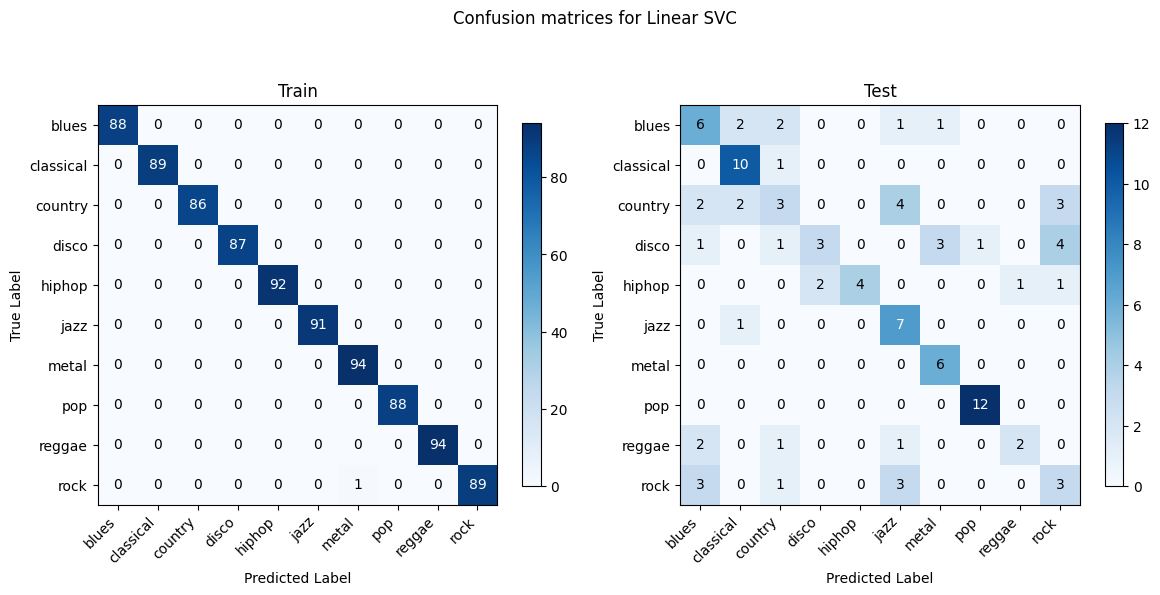

In [10]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', C=2, random_state=RANDOM_STATE)
svm_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(svm_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(svm_classifier, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for Linear SVC')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 56.0000%, 44 mismatches out of 100 samples
(Averaged) Test precision: 0.5929, recall: 0.5862, f1 score: 0.5515


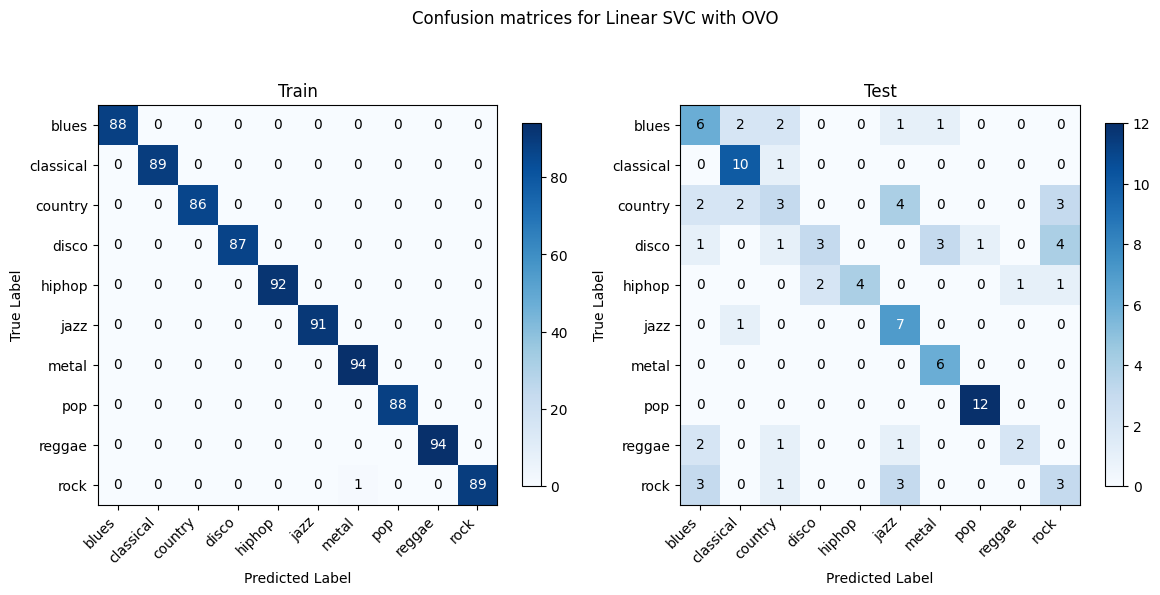

In [11]:
from sklearn.svm import SVC

ovo_svm = SVC(kernel='linear', decision_function_shape='ovo', C=2, random_state=RANDOM_STATE)
ovo_svm.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(ovo_svm, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(ovo_svm, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for Linear SVC with OVO')

Model fitting finished
Train accuracy: 74.8610%, 226 mismatches out of 899 samples
(Averaged) Train precision: 0.7660, recall: 0.7457, f1 score: 0.7415
Test accuracy: 26.0000%, 74 mismatches out of 100 samples
(Averaged) Test precision: 0.3148, recall: 0.3031, f1 score: 0.1830


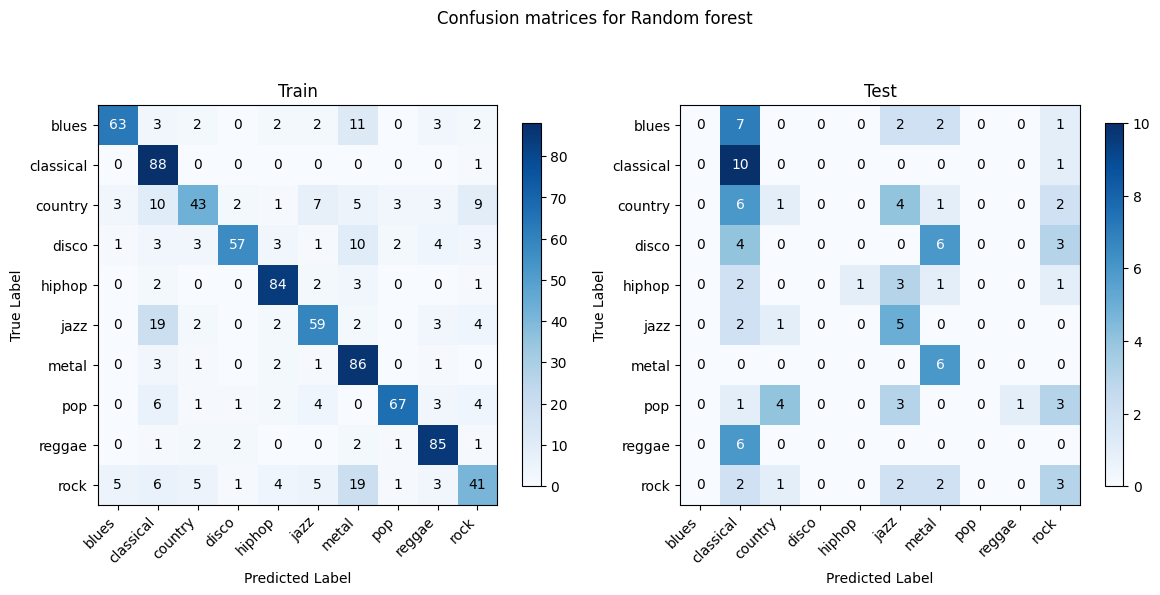

In [12]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(n_estimators=100,
                                                max_depth=3,
                                                random_state=RANDOM_STATE)
rand_forest_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(rand_forest_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(rand_forest_classifier, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for Random forest')

Model fitting finished
Train accuracy: 84.4271%, 140 mismatches out of 899 samples
(Averaged) Train precision: 0.8648, recall: 0.8436, f1 score: 0.8448
Test accuracy: 61.0000%, 39 mismatches out of 100 samples
(Averaged) Test precision: 0.6451, recall: 0.6508, f1 score: 0.6162


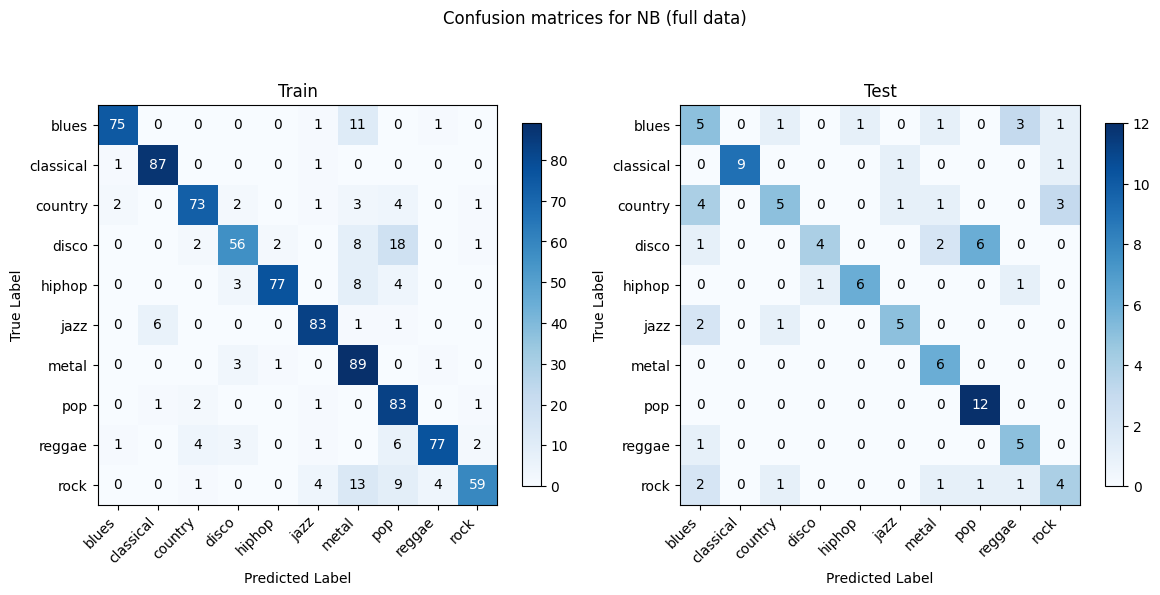

In [13]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([X_train_flat, X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(gnb_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for NB (full data)')

Model fitting finished
Train accuracy: 57.9533%, 378 mismatches out of 899 samples
(Averaged) Train precision: 0.6591, recall: 0.5800, f1 score: 0.5631
Test accuracy: 13.0000%, 87 mismatches out of 100 samples
(Averaged) Test precision: 0.4229, recall: 0.1250, f1 score: 0.0650


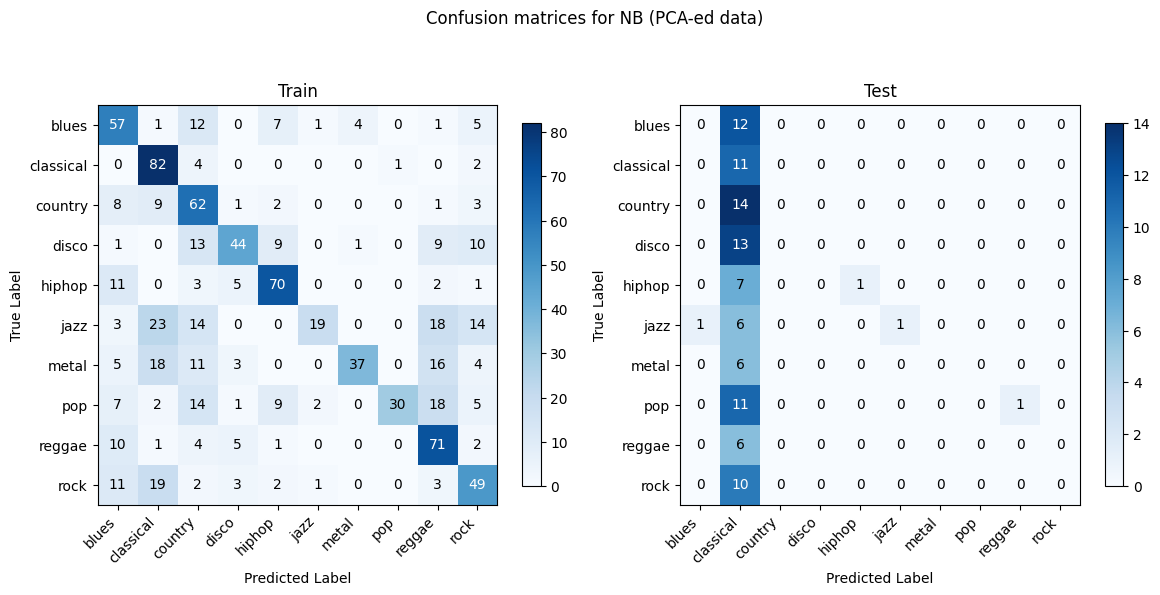

In [14]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier_pca = GaussianNB()
gnb_classifier_pca.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(gnb_classifier_pca, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier_pca, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for NB (PCA-ed data)')

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost_classifier = GradientBoostingClassifier(subsample=0.8, max_depth=2, random_state=RANDOM_STATE)
xgboost_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(xgboost_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(xgboost_classifier, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             titles=('Train', 'Test'),
                             grand_title='Confusion matrices for XGboost')

KeyboardInterrupt: 

Prepare dataset for K fold 

In [16]:
data_flat = data.view(data.shape[0], -1).cpu().numpy()
data_scaled = scaler.fit_transform(data_flat)
reduced_data = pca.fit_transform(data_scaled)

In [17]:
#Training xgboost classifier takes more time. For quick testing, feel free to delete it from the list
#current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier, xgboost_classifier] 
current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier, gnb_classifier_pca]
#current_model_names = ["logistic", "svm", "ovo_svm", "rand_forest_classifier", "gnb_classifier", "xgboost_classifier"]
current_model_names = ["logistic", "svm", "ovo_svm", "rand_forest_classifier", "gnb_classifier", "gnb_classifier_pca"]

In [18]:
from audio_toolbox.metrics import kfold_validation
import warnings
from IPython.utils import io

N_SPLITS = 5

accs = {}
f1s = {}

data_full = data.reshape(data.shape[0], -1)
data_reduced = pca.transform(data.reshape(data.shape[0], -1))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, name in zip(current_models, current_model_names):
        print(f"Benchmarking {name}")
        dt = data_full
        if name != 'gnb_classifier':
            dt = data_reduced
        avg_acc, avg_precision, avg_recall, avg_f1 = kfold_validation(model, dt, label, n_splits=N_SPLITS)
        accs[name] = avg_acc
        f1s[name] = avg_f1
        print(f"Average Accuracy: {avg_acc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print("\n")


Benchmarking logistic
Average Accuracy: 45.0447
Average Precision: 0.4399
Average Recall: 0.4507
Average F1 Score: 0.4340


Benchmarking svm
Average Accuracy: 51.8553
Average Precision: 0.5114
Average Recall: 0.5187
Average F1 Score: 0.5050


Benchmarking ovo_svm
Average Accuracy: 51.8553
Average Precision: 0.5114
Average Recall: 0.5187
Average F1 Score: 0.5050


Benchmarking rand_forest_classifier
Average Accuracy: 39.6397
Average Precision: 0.3684
Average Recall: 0.3967
Average F1 Score: 0.3329


Benchmarking gnb_classifier
Average Accuracy: 56.6513
Average Precision: 0.5759
Average Recall: 0.5665
Average F1 Score: 0.5531


Benchmarking gnb_classifier_pca
Average Accuracy: 43.7467
Average Precision: 0.4506
Average Recall: 0.4376
Average F1 Score: 0.4188




In [19]:
import matplotlib.pyplot as plt
import numpy as np
def create_bar_chart(data, title, ylabel):
    models = list(data.keys())
    scores = list(data.values())
    fig, ax = plt.subplots()
    bar_positions = np.arange(len(models))
    ax.bar(bar_positions, scores, color='skyblue')
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

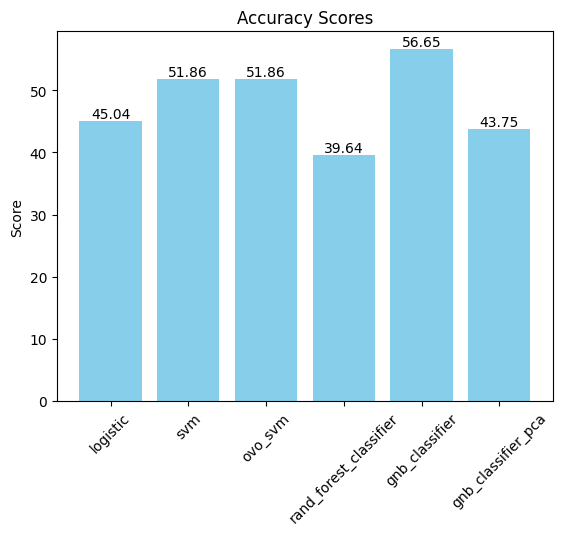

In [20]:
create_bar_chart(accs, "Accuracy Scores", "Score")

(0.0, 0.7)

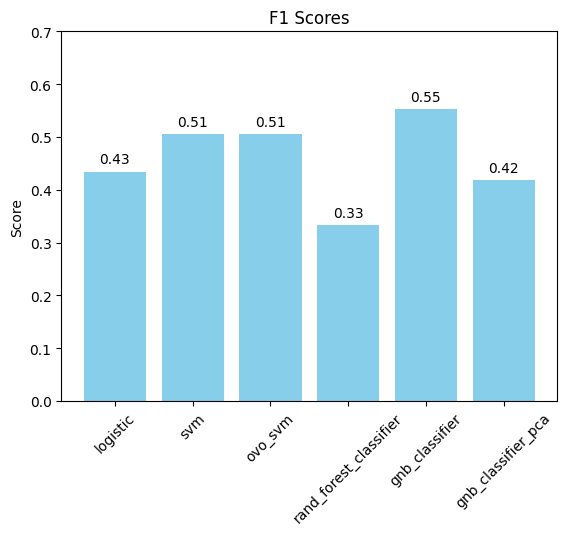

In [21]:
create_bar_chart(f1s, "F1 Scores", "Score")
plt.ylim(top=0.7)